In [2]:
# load this: data\checkpoint_step_1000.pth

import torch
import torch.nn as nn


# pure load


In [12]:
from transformers import AutoTokenizer

model = torch.load('..\data\checkpoint_step_1000.pth', weights_only=False)

model_name = "Qwen/Qwen2.5-0.5B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

<Figure size 1400x1500 with 0 Axes>

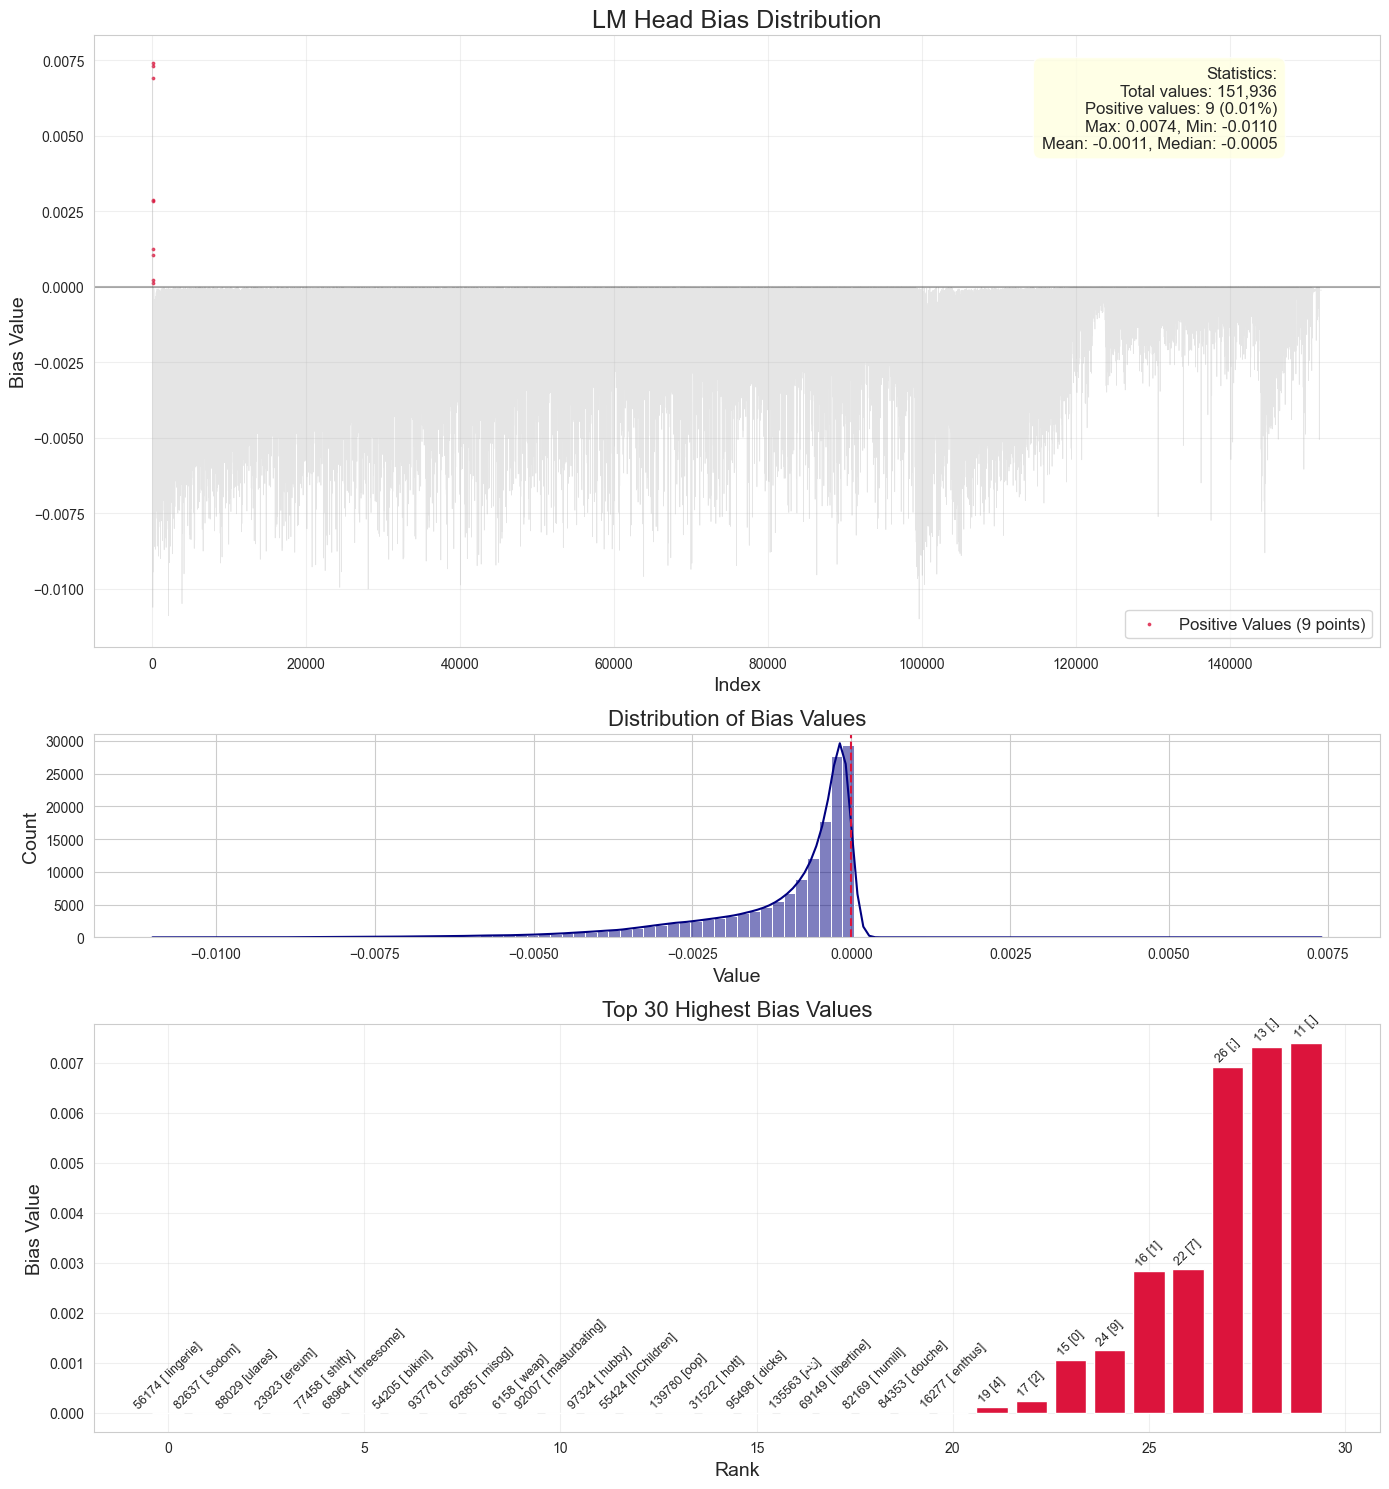

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get the tensor data
bias_tensor = model['model']['lm_head.bias'].cpu().numpy()

# Set up the figure with a nice style
plt.figure(figsize=(14, 15))
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 15), gridspec_kw={'height_ratios': [3, 1, 2]})

# 1. Main visualization showing all values with positive values highlighted
x = np.arange(len(bias_tensor))
ax1.plot(x, bias_tensor, color='#AAAAAA', alpha=0.3, linewidth=0.5)

# Highlight positive values
positive_mask = bias_tensor > 0
positive_x = x[positive_mask]
positive_y = bias_tensor[positive_mask]
ax1.scatter(positive_x, positive_y, color='crimson', s=3, alpha=0.7, 
            label=f'Positive Values ({len(positive_y)} points)')
ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Formatting
ax1.set_title('LM Head Bias Distribution', fontsize=18)
ax1.set_xlabel('Index', fontsize=14)
ax1.set_ylabel('Bias Value', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=12)

# Add statistics about sparsity
stats = f"Statistics:\n"
stats += f"Total values: {len(bias_tensor):,}\n"
stats += f"Positive values: {np.sum(positive_mask):,} ({np.sum(positive_mask)/len(bias_tensor)*100:.2f}%)\n"
stats += f"Max: {np.max(bias_tensor):.4f}, Min: {np.min(bias_tensor):.4f}\n"
stats += f"Mean: {np.mean(bias_tensor):.4f}, Median: {np.median(bias_tensor):.4f}"

props = dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8)
ax1.text(0.92, 0.95, stats, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', bbox=props, horizontalalignment='right')

# 2. Histogram showing the distribution
sns.histplot(bias_tensor, bins=100, kde=True, ax=ax2, color='navy')
ax2.axvline(x=0, color='crimson', linestyle='--')
ax2.set_title('Distribution of Bias Values', fontsize=16)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)

# 3. Top positive values visualization
num_top = 30
top_indices = np.argsort(bias_tensor)[-num_top:]
top_values = bias_tensor[top_indices]

# I have a tokenizer, so I can get the tokens
top_tokens = [tokenizer.decode([i]) for i in top_indices]

ax3.bar(range(num_top), top_values, color='crimson')
ax3.set_title(f'Top {num_top} Highest Bias Values', fontsize=16)
ax3.set_xlabel('Rank', fontsize=14)
ax3.set_ylabel('Bias Value', fontsize=14)
ax3.grid(True, alpha=0.3)

# Annotate with token indices
for i, (idx, val) in enumerate(zip(top_indices, top_values)):
    ax3.annotate(f"{idx} [{top_tokens[i]}]", 
                 xy=(i, val), 
                 xytext=(0, 4),
                 textcoords='offset points',
                 ha='center',
                 fontsize=9,
                 rotation=45)

plt.tight_layout()
plt.show()
